# Geometric Computer Vision: Final Project
This notebook contains a revisited implementation of the paper: **Shape Non-rigid Kinematics (SNK): A Zero-Shot Method for Non-Rigid Shape Matching via Unsupervised Functional Map Regularized Reconstruction** by Attaiki and Ovsjanikov (2024).

## Imports

In [1]:
from pyFM.functional import FunctionalMapping
import numpy as np
import trimesh
from pyFM.mesh import TriMesh
import torch
from torch_geometric.data import Batch
from diffusion_net import DiffusionData, DiffusionOperatorsTransform, DiffusionNet
from prism_decoder import PrismDecoder
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from loss import PrismRegularizationLoss

## Load meshes
Let's first load the meshes of two dogs modified (non-rigid deformation using Blender):

In [2]:
# load some meshes
obj1 = r"./Samples/dog_small.obj"
obj2 = r"./Samples/dog_small_after_torture.obj"
mesh1, mesh2 = TriMesh(obj1), TriMesh(obj2)

## Compute correspondance from mesh2 to mesh1 using functional maps
I chose the pyFM package investigated in HW3 to compute a correspondance map between the meshes, using WKS descriptors:

In [3]:
process_params = {
    'n_ev': (70, 70),  # Number of eigenvalues on source and Target
    'subsample_step': 20,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}           
model = FunctionalMapping(mesh1, mesh2)
model.preprocess(**process_params, verbose=False)
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 0
}
model.fit(**fit_params, verbose=False)
p2p_21 = model.get_p2p(n_jobs=1)

## Visualization using meshplot package

In [4]:
import meshplot as mp

def double_plot_mp(myMesh1,myMesh2,cmap1=None,cmap2=None):
    p = mp.plot(myMesh1.vertlist, myMesh1.facelist, c=cmap1)
    v2_translated = myMesh2.vertlist.copy()
    f2_translated = myMesh2.facelist.copy()
    myMesh2_translated = TriMesh(v2_translated, f2_translated)
    myMesh2_translated.vertlist[:,0] = myMesh2_translated.vertlist[:,0] + 30 
    p.add_mesh(myMesh2_translated.vertlist, myMesh2_translated.facelist, c=cmap2)
    
def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot_mp(mesh1,mesh2,cmap1,cmap2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0212688…

## Compute latent vector
Following section 4.2 in the paper, we compute a latent vector (of length d1) per feature using DiffusionNet++ module, then apply max pooling to get a vector l of length d1.

Then we aim to reconstruct the first shape by concatenating l to each feature of the second mesh and passing those to the decoder. 

In [5]:
def compute_l(my_batch, diffusion_net):
    my_batch.x = my_batch.pos.clone()  # set the input features to the positions
    output = diffusion_net(my_batch)
    l = output.x.max(dim=0).values
    return l
    
def reconstruct_s2(my_batch2, v2_t, l, decoder):
    l_expanded = l.unsqueeze(0).repeat(v2_t.shape[0],1)
    my_batch2.x = torch.cat((v2_t,l_expanded),dim=1) #.unsqueeze(0)
    # my_batch2.pos = my_batch2.pos.unsqueeze(0) #my_batch2.pos.clone()   .clone() # set the input features to the positions
    s3 = decoder(my_batch2)
    return s3

Prepare first mesh for compatibility with DiffusionNet++ model

In [6]:
mesh1_diff = trimesh.load(obj1)
v1, f1 = np.array(mesh1.vertices), np.array(mesh1.faces)
v1_t = torch.from_numpy(v1)
f1_t = torch.from_numpy(f1)
data1 = DiffusionData(pos=v1_t, face=f1_t.T)
diffusion_transform = DiffusionOperatorsTransform(n_eig=50)  #97 compute the diffusion net operators with 97 eigenvalues
data1 = diffusion_transform(data1)
my_batch = Batch.from_data_list([data1])

Prepare second mesh for compatibility with DiffusionNet++ model

In [7]:
mesh2_diff = trimesh.load(obj2)
v2, f2 = np.array(mesh2.vertices), np.array(mesh2.faces)
data2 = DiffusionData(pos=torch.from_numpy(v2), face=torch.from_numpy(f2).T)
diffusion_transform = DiffusionOperatorsTransform(n_eig=50)  #97 compute the diffusion net operators with 97 eigenvalues
data2 = diffusion_transform(data2)
my_batch2 = Batch.from_data_list([data2])
my_batch2.pos = my_batch2.pos.unsqueeze(0) 
#######
v2_t = torch.Tensor(v2)

Make parameters differentiable - for backward propagation

In [8]:
my_batch.pos.requires_grad = True
v2_t.requires_grad = True
my_batch2.pos.requires_grad = True

## Prepare visualization functions

In [9]:
def double_plot(myMesh1, myMesh2, cmap1=None, cmap2=None, title1='Mesh1',title2='Mesh2'):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_trisurf(myMesh1.vertlist[:, 0], myMesh1.vertlist[:, 1], myMesh1.vertlist[:, 2],
                     triangles=myMesh1.facelist, cmap='viridis', facecolors=cmap1)
    ax1.set_title(title1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_trisurf(myMesh2.vertlist[:, 0], myMesh2.vertlist[:, 1], myMesh2.vertlist[:, 2],
                     triangles=myMesh2.facelist, cmap='viridis', facecolors=cmap2)
    ax2.set_title(title2)

def visu_face_colors(s1_faces_raw, s1_faces, s2_faces, s3_faces):
    cmap = cm.get_cmap('viridis', s3_faces.shape[0])  # Use a colormap with 500 distinct colors
    face_colors = cmap(np.linspace(0, 1, s3_faces.shape[0]))
    
    average_z = np.mean(s2_faces[:, :, 2], axis=1)
    sorted_indices = np.argsort(average_z)
    
    sorted_s3_faces = s3_faces[sorted_indices]
    sorted_s2_faces = s2_faces[sorted_indices]
    sorted_s1_faces = s1_faces[sorted_indices]
    fig = plt.figure()
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')
    for i, face in enumerate(s3_faces):
        # poly3d = [[vertices[vert_idx] for vert_idx in face]]
        poly3d_1 = [sorted_s1_faces[i]]
        poly3d_2 = [sorted_s2_faces[i]]
        poly3d_1_raw = [s1_faces_raw[i]]
        poly3d_3 = [sorted_s3_faces[i]]
        ax1.add_collection3d(Poly3DCollection(poly3d_1, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
        ax1.add_collection3d(Poly3DCollection(poly3d_1_raw, facecolors='b', linewidths=1, edgecolors=None, alpha=.1))
        ax2.add_collection3d(Poly3DCollection(poly3d_2, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
        ax3.add_collection3d(Poly3DCollection(poly3d_3, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
    ax1.set_xlim([s1_faces[:,:,0].min(), s1_faces[:,:,0].max()])
    ax1.set_ylim([s1_faces[:,:,1].min(), s1_faces[:,:,1].max()])
    ax1.set_zlim([s1_faces[:,:,2].min(), s1_faces[:,:,2].max()])
    ax2.set_xlim([s2_faces[:,:,0].min(), s2_faces[:,:,0].max()])
    ax2.set_ylim([s2_faces[:,:,1].min(), s2_faces[:,:,1].max()])
    ax2.set_zlim([s2_faces[:,:,2].min(), s2_faces[:,:,2].max()])
    ax3.set_xlim([s3_faces[:,:,0].min(), s3_faces[:,:,0].max()])
    ax3.set_ylim([s3_faces[:,:,1].min(), s3_faces[:,:,1].max()])
    ax3.set_zlim([s3_faces[:,:,2].min(), s3_faces[:,:,2].max()])
    plt.show()

## Handling face matching for visualization

In [10]:
def compute_centroid(face):
    return np.mean(face, axis=0)

def find_closest_faces(lf1, lf2):
    centroids_lf1 = np.array([compute_centroid(face) for face in lf1])
    centroids_lf2 = np.array([compute_centroid(face) for face in lf2])
    
    closest_faces = []
    closest_faces_idx = []
    
    for centroid in centroids_lf2:
        distances = np.linalg.norm(centroids_lf1 - centroid, axis=1)
        closest_face_idx = np.argmin(distances)
        while closest_face_idx in closest_faces_idx:
            distances[closest_face_idx] = max(distances) + 1
            closest_face_idx = np.argmin(distances)
        closest_faces.append(lf1[closest_face_idx])
        closest_faces_idx.append(closest_face_idx)
    return closest_faces_idx

In [11]:
v1s = my_batch.pos.reshape(-1, 3)
f1s = my_batch.face.t()
s1_faces_tmp = v1s[f1s].detach().numpy()

## Initialization of the models (DiffusionNet, PrismDecoder)

In [12]:
L_SPACE_SIZE = 42
diffusion_net = DiffusionNet(3, L_SPACE_SIZE)
decoder = PrismDecoder(v1.shape[1]+L_SPACE_SIZE, v1.shape[0])

## Training process

  0%|                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_12508\321993680.py:15: UserWarning: Using a target size (torch.Size([1, 487, 3])) that is different to the input size (torch.Size([487, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(torch.Tensor(v1_remapped),s3.features)
C:\Users\Hadassa-Port\Desktop\hadassa\Toar 2\Semester 1\Geometric Computer Vision\SNK\loss.py:28: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ..\aten\src\ATen\native\Cross.cpp:66.)
  normal = to

Epoch 0: MSE loss = 380.8232421875
Epoch 0: Energy loss = 55.170536041259766


C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_12508\2963957283.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', s3_faces.shape[0])  # Use a colormap with 500 distinct colors


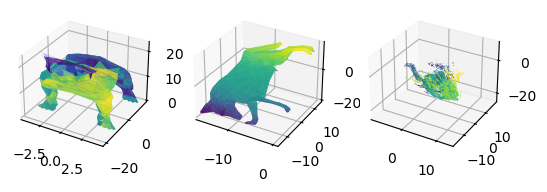

37.519310:   1%|█▌                                                                                                                                                              | 20/2000 [00:48<33:17,  1.01s/it]

Epoch 20: MSE loss = 37.519309997558594
Epoch 20: Energy loss = 0.06417781859636307


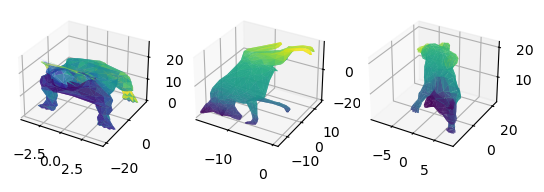

18.741827:   2%|███▏                                                                                                                                                            | 40/2000 [01:34<47:36,  1.46s/it]

Epoch 40: MSE loss = 18.7418270111084
Epoch 40: Energy loss = 0.002584312343969941


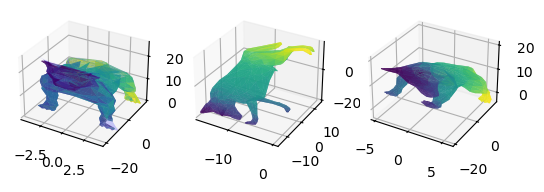

16.039995:   3%|████▊                                                                                                                                                           | 60/2000 [02:10<32:58,  1.02s/it]

Epoch 60: MSE loss = 16.039995193481445
Epoch 60: Energy loss = 0.00724763935431838


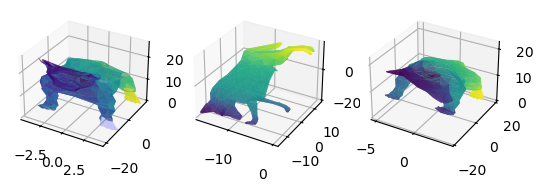

15.875034:   4%|██████▍                                                                                                                                                         | 80/2000 [02:40<32:13,  1.01s/it]

Epoch 80: MSE loss = 15.87503433227539
Epoch 80: Energy loss = 0.006988008506596088


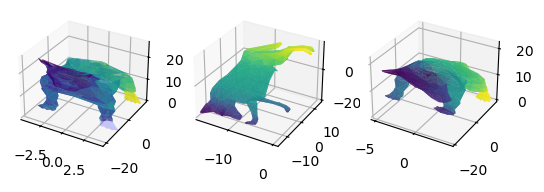

15.714131:   5%|███████▉                                                                                                                                                       | 100/2000 [03:11<32:33,  1.03s/it]

Epoch 100: MSE loss = 15.714131355285645
Epoch 100: Energy loss = 0.006078184582293034


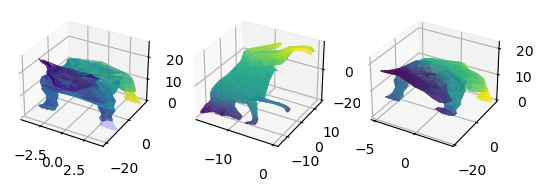

14.708385:  10%|███████████████▉                                                                                                                                               | 200/2000 [05:04<31:01,  1.03s/it]

Epoch 200: MSE loss = 14.708385467529297
Epoch 200: Energy loss = 0.01923668012022972


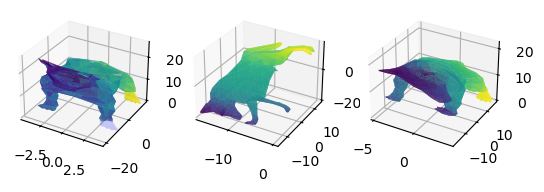

14.443155:  15%|███████████████████████▊                                                                                                                                       | 300/2000 [07:04<29:41,  1.05s/it]

Epoch 300: MSE loss = 14.443155288696289
Epoch 300: Energy loss = 0.02276437170803547


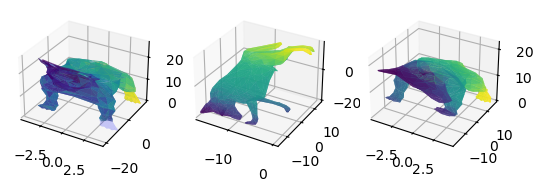

14.251207:  20%|███████████████████████████████▊                                                                                                                               | 400/2000 [08:58<25:51,  1.03it/s]

Epoch 400: MSE loss = 14.25120735168457
Epoch 400: Energy loss = 0.024506928399205208


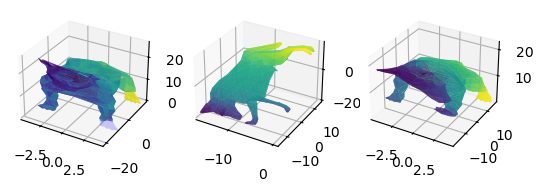

14.017374:  25%|███████████████████████████████████████▊                                                                                                                       | 500/2000 [10:53<23:57,  1.04it/s]

Epoch 500: MSE loss = 14.017374038696289
Epoch 500: Energy loss = 0.028628913685679436


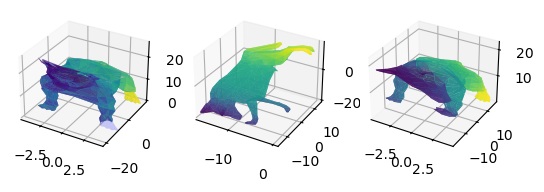

13.603838:  30%|███████████████████████████████████████████████▋                                                                                                               | 600/2000 [12:47<22:35,  1.03it/s]

Epoch 600: MSE loss = 13.603837966918945
Epoch 600: Energy loss = 0.032199397683143616


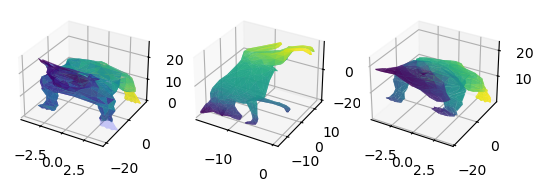

13.452585:  35%|███████████████████████████████████████████████████████▋                                                                                                       | 700/2000 [14:36<22:22,  1.03s/it]

Epoch 700: MSE loss = 13.452585220336914
Epoch 700: Energy loss = 0.03310574218630791


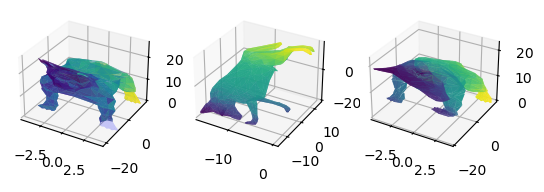

12.586988:  40%|███████████████████████████████████████████████████████████████▌                                                                                               | 800/2000 [16:26<22:13,  1.11s/it]

Epoch 800: MSE loss = 12.58698844909668
Epoch 800: Energy loss = 0.0529869943857193


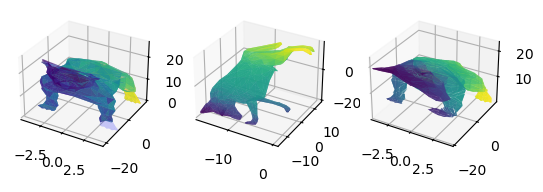

12.083807:  45%|███████████████████████████████████████████████████████████████████████▌                                                                                       | 900/2000 [18:20<19:17,  1.05s/it]

Epoch 900: MSE loss = 12.083806991577148
Epoch 900: Energy loss = 0.05478142201900482


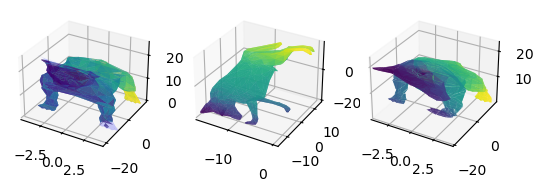

11.784428:  50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 1000/2000 [20:11<16:32,  1.01it/s]

Epoch 1000: MSE loss = 11.784427642822266
Epoch 1000: Energy loss = 0.05672043561935425


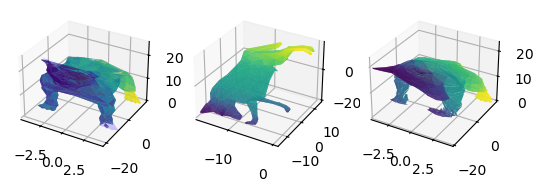

11.695845:  55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1100/2000 [22:26<20:13,  1.35s/it]

Epoch 1100: MSE loss = 11.695844650268555
Epoch 1100: Energy loss = 0.05680251121520996


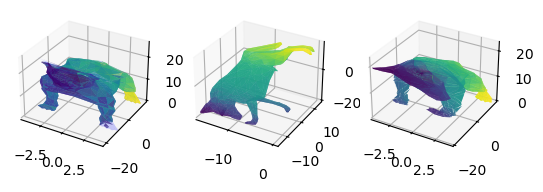

11.427905:  60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1200/2000 [24:51<24:02,  1.80s/it]

Epoch 1200: MSE loss = 11.427905082702637
Epoch 1200: Energy loss = 0.06552743166685104


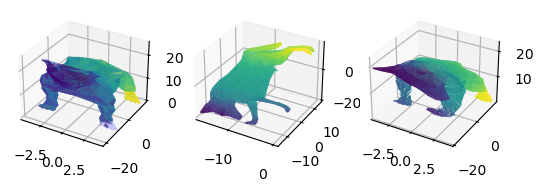

11.417137:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1300/2000 [27:07<11:57,  1.03s/it]

Epoch 1300: MSE loss = 11.417137145996094
Epoch 1300: Energy loss = 0.0595039464533329


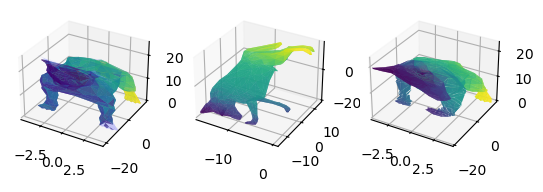

11.263186:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1400/2000 [28:56<10:09,  1.02s/it]

Epoch 1400: MSE loss = 11.263185501098633
Epoch 1400: Energy loss = 0.06322402507066727


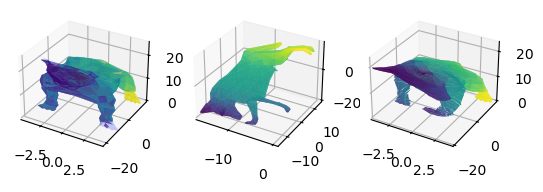

11.132992:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1500/2000 [30:49<08:45,  1.05s/it]

Epoch 1500: MSE loss = 11.132991790771484
Epoch 1500: Energy loss = 0.06326287239789963


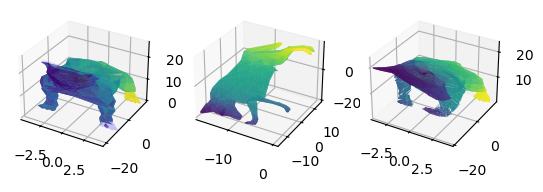

11.285318:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1600/2000 [32:40<06:39,  1.00it/s]

Epoch 1600: MSE loss = 11.285318374633789
Epoch 1600: Energy loss = 0.056058600544929504


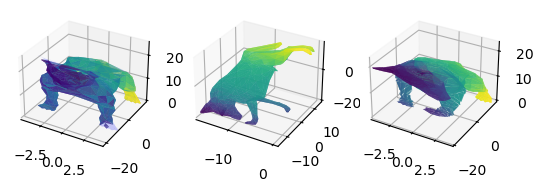

11.038894:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1700/2000 [34:30<04:51,  1.03it/s]

Epoch 1700: MSE loss = 11.038893699645996
Epoch 1700: Energy loss = 0.05881454795598984


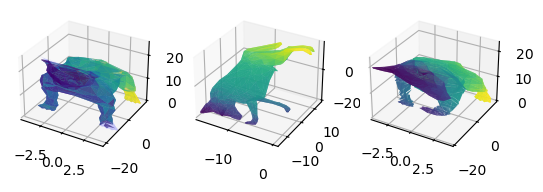

10.967781:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1800/2000 [36:20<03:22,  1.01s/it]

Epoch 1800: MSE loss = 10.967781066894531
Epoch 1800: Energy loss = 0.062212999910116196


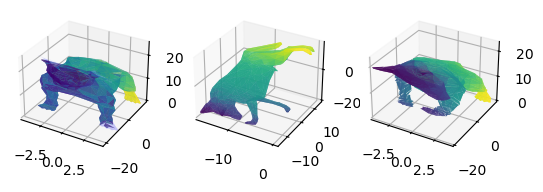

10.702518:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1900/2000 [38:13<01:37,  1.03it/s]

Epoch 1900: MSE loss = 10.702518463134766
Epoch 1900: Energy loss = 0.06658665835857391


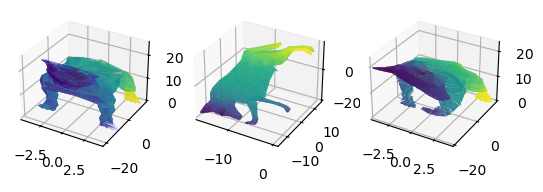

10.562922: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [40:08<00:00,  1.20s/it]


In [13]:
# %debug
lambda_E = 30
losses_MSE = []
losses_energy = []
losses = []
get_energy_loss = PrismRegularizationLoss(100)
optimizer_diffnet = optim.AdamW(diffusion_net.parameters() ,lr=0.001, weight_decay=0.001)
optimizer_decoder = optim.AdamW(decoder.parameters() ,lr=0.001, weight_decay=0.001)
for epoch in (pbar:=tqdm(range(2000))):
    l = compute_l(my_batch, diffusion_net)
    l.retain_grad()
    s3 = reconstruct_s2(my_batch2, v2_t, l, decoder)
    s3.features.retain_grad()
    v1_remapped = v1[p2p_21]
    loss = torch.nn.functional.mse_loss(torch.Tensor(v1_remapped),s3.features)
    loss_E = get_energy_loss(s3.transformed_prism, s3.rotations, s3.pos.reshape(-1, 3), s3.face) 
    total_loss = loss + loss_E*lambda_E
    losses_MSE.append(loss.detach())
    losses_energy.append(loss_E.detach())
    losses.append(total_loss.detach())
    pbar.set_description(f"{loss.detach():3f}")
    total_loss.retain_grad()
    total_loss.backward()
    # import ipdb; ipdb.set_trace()
    optimizer_diffnet.step()
    optimizer_diffnet.zero_grad()
    optimizer_decoder.step()
    optimizer_decoder.zero_grad()
    if (epoch%20 == 0 and epoch<=101) or epoch%100 == 0:
        print(f'Epoch {epoch}: MSE loss = {loss}')
        print(f'Epoch {epoch}: Energy loss = {loss_E}')
        verts = my_batch2.pos.reshape(-1, 3)
        faces = my_batch2.face.t()
        s2_faces = verts[faces].detach().numpy()
        s3_faces = s3.transformed_prism.detach().squeeze(0).numpy()
        closest_faces_idx = find_closest_faces(s1_faces_tmp, s3_faces) #find_closest_faces(s3_faces, s1_faces_tmp)
        s1_faces = s1_faces_tmp[closest_faces_idx]
        visu_face_colors(s1_faces_tmp, s1_faces, s2_faces, s3_faces)
        plt.show()

## Plot the loss functions

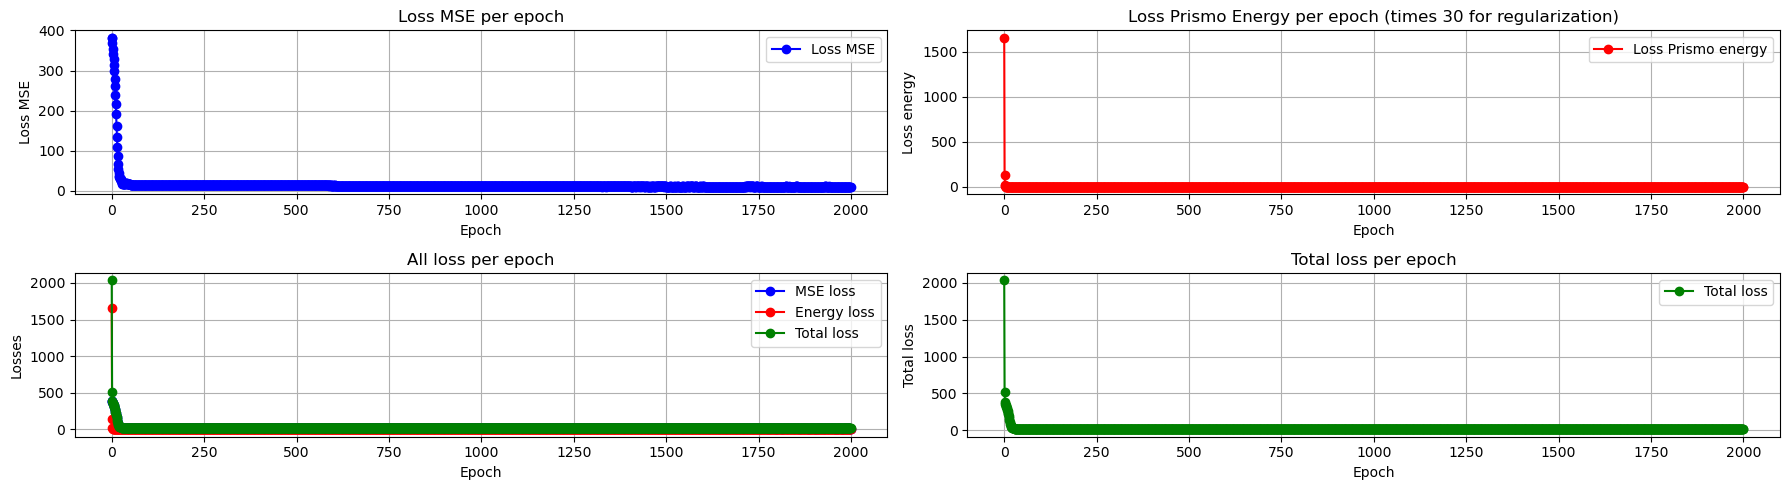

In [14]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 5))
l_energy = [lambda_E*a for a in losses_energy]
# Plot MSE loss
axs[0,0].plot(range(len(losses_MSE)), losses_MSE, label='Loss MSE', marker='o', color='b')
axs[0,0].set_xlabel('Epoch'); axs[0,0].set_ylabel('Loss MSE')
axs[0,0].set_title('Loss MSE per epoch'); axs[0,0].legend(); axs[0,0].grid(True)

# Plot Energy loss
axs[0,1].plot(range(len(losses_energy)), l_energy, label='Loss Prismo energy', marker='o', color='r')
axs[0,1].set_xlabel('Epoch'); axs[0,1].set_ylabel('Loss energy')
axs[0,1].set_title(f'Loss Prismo Energy per epoch (times {lambda_E} for regularization)'); axs[0,1].legend(); axs[0,1].grid(True)

# Plot total loss
axs[1,0].plot(range(len(losses_MSE)), losses_MSE, label='MSE loss', marker='o', color='b')
axs[1,0].plot(range(len(l_energy)), l_energy, label='Energy loss', marker='o', color='r')
axs[1,0].plot(range(len(losses)), losses, label='Total loss', marker='o', color='g')
axs[1,0].set_xlabel('Epoch'); axs[1,0].set_ylabel('Losses')
axs[1,0].set_title('All loss per epoch'); axs[1,0].legend(); axs[1,0].grid(True)

# Plot total loss
axs[1,1].plot(range(len(losses)), losses, label='Total loss', marker='o', color='g')
axs[1,1].set_xlabel('Epoch'); axs[1,1].set_ylabel('Total loss')
axs[1,1].set_title('Total loss per epoch'); axs[1,1].legend(); axs[1,1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Save first shape (remapped based on functional map) and its reconstruction.

In [15]:
np.save('shape1_baseline.npy', v1_remapped)
np.save('shape2_reconstruction.npy', s3.features.detach().squeeze(0).numpy())
